In [2]:
import torch

print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

12.8
NVIDIA GeForce RTX 4060 Laptop GPU


In [66]:
import torch

# Check and report VRAM usage
# torch.cuda.memory_allocated() gives the current tensor memory usage in bytes.
allocated_bytes = torch.cuda.memory_allocated('cuda')
allocated_mb = allocated_bytes / (1024 * 1024)

reserved_bytes = torch.cuda.memory_reserved('cuda')
reserved_mb = reserved_bytes / (1024 * 1024)

print("\n--- VRAM USAGE REPORT ---")
print(f"Memory Allocated: {allocated_mb:.2f} MB")
print(f"Memory Reserved:  {reserved_mb:.2f} MB")
print("-------------------------\n")
#


--- VRAM USAGE REPORT ---
Memory Allocated: 38.50 MB
Memory Reserved:  1874.00 MB
-------------------------



In [25]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

training_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.SquareSymmetry(p=0.5),
    A.RandomCrop(height=180, width=180,  p=0.8),
    A.Resize(height=224, width=224),
    A.RandomRain(slant_range=(-15,15), drop_length=15, drop_width=1, rain_type="default", blur_value=7 ,p=0.4),
    A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), p=0.3),
    A.Rotate(limit=45, p=0.4),
    A.GaussNoise(std_range=(0.1, 0.2), per_channel=True  ,p=0.3),
    A.ColorJitter(brightness=(0.8, 1.1), contrast=(0.8, 1.1), saturation=(0.8, 1.1), hue=(-0.5, 0.5)),
    A.CoarseDropout(num_holes_range=(1, 5), hole_height_range=(0.1, 0.25),
                        hole_width_range=(0.1, 0.25), fill=0, p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

validation_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

experiment_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.6),
    A.VerticalFlip(p=0.6),
    A.Rotate(limit=(-45,45), p=0.7),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [26]:
import cv2
from torchvision import datasets

class CustomDataset(datasets.ImageFolder):

    def __getitem__(self, index):

        path, target = self.samples[index]

        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, target

    def __len__(self):
        return len(self.samples)

In [65]:
import torchvision.models as models
import torch.nn as nn

class PestClassifierMobileNetV2(nn.Module):

    def __init__(self, num_classes):
        super(PestClassifierMobileNetV2, self).__init__()

        # get model
        self.base_model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V2')

        # Froze feature extraction layer to retain weights.
        # for params in self.base_model.parameters():
        #     params.requires_grad = False

        # get number of features
        num_filters = self.base_model.classifier[1].in_features

        # Hyperparameter tuning: new layer for 6 rice pests.
        self.base_model.classifier[1] = nn.Linear(num_filters, num_classes)

    # Forward propagation
    def forward(self, x):

       features = self.base_model.features(x)

       features = F.adaptive_avg_pool2d(features, output_size=(1, 1)).reshape(features.shape[0], -1)

       features = self.base_model.classifier(features)

       return features

    def unfreeze_last_block(self):

        print("\nUnfreezing last block of feature extraction.")

        for param in self.base_model.features[-1].parameters():
            param.requires_grad = True

    def unfreeze_final_invert_residual(self):

        print('\nUnfreezing final inverse residual feature extraction.')

        for param in self.base_model.features[-2].parameters():
            param.requires_grad = True

    def unfreeze_second_last_invert_residual(self):
        print('\nUnfreezing second last inverse residual feature extraction.')

        for param in self.base_model.features[-3].parameters():
            param.requires_grad = True

    def unfreeze_third_last_invert_residual(self):
        print('\nUnfreezing third last inverse residual feature extraction.')

        for param in self.base_model.features[-4].parameters():
            param.requires_grad = True

    def freeze_last_block(self):
        print("\nFreezing last block of feature extraction.")
        for param in self.base_model.features[-1].parameters():
            param.requires_grad = False


In [29]:
import torch
from tqdm import tqdm

def train_and_test(model, optimizer, criterion, train_dataloader, test_dataloader, num_epoch, device):
    train_losses = []
    test_losses = []
    accuracies = []
    best_accuracy = 0.0

    for epoch in range(num_epoch):
        # --- TRAINING PHASE ---
        model.train()
        running_train_loss = 0.0
        train_pbar = tqdm(train_dataloader, desc=f"Train epoch: {epoch+1}")
        for data, labels in train_pbar:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        training_loss = running_train_loss / len(train_dataloader)
        train_losses.append(training_loss)

        # --- TESTING PHASE ---
        model.eval()
        running_test_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_dataloader, desc=f"Test epoch: {epoch+1}"):
                inputs, labels = inputs.to(device), labels.to(device)

                output_loss = model(inputs)
                loss = criterion(output_loss, labels)
                running_test_loss += loss.item()
                _, predicted = torch.max(output_loss.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        testing_loss = running_test_loss / len(test_dataloader)
        test_losses.append(testing_loss)
        accuracy = 100 * correct_predictions / total_samples
        accuracies.append(accuracy)

        epoch_summary = f'Epoch {epoch+1}/{num_epoch} | Train Loss: {training_loss:.4f} | Test Loss: {testing_loss:.4f} | Accuracy: {accuracy:.2f}%'

        if device.type == 'cuda':
            allocated_gb = torch.cuda.memory_allocated() / (1024 ** 3)
            reserved_gb = torch.cuda.memory_reserved() / (1024 ** 3)
            epoch_summary += f' | GPU Memory (Alloc/Reserved): {allocated_gb:.2f}/{reserved_gb:.3f} GB'

        tqdm.write(epoch_summary)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'models/SMobileNetV2_rice_pest_classificationV8.pt')

        # scheduler.step(testing_loss)

    tqdm.write('Phase done!')

    return {'train_loss': train_losses, 'test_loss': test_losses, 'accuracy': accuracies}, best_accuracy

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_training_result(*results):

    full_train_loss = []
    full_test_loss = []

    for res in results:
        full_train_loss.extend(res.get('train_loss', []))
        full_test_loss.extend(res.get('test_loss', []))

    total_epochs = len(full_train_loss)
    if total_epochs == 0:
        print("No data to plot.")
        return

    epochs = range(1, total_epochs + 1)

    data = {
        'Epoch': epochs,
        'Training Loss': full_train_loss,
        'Testing Loss': full_test_loss,
    }

    df = pd.DataFrame(data)

    df_long = df.melt(id_vars=['Epoch'], var_name='Loss Type', value_name='Loss')

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_long, x='Epoch', y='Loss', hue='Loss Type', marker='o')

    plt.title('Training and Testing Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy(*results):

    full_accuracy = []

    for result in results:
        accuracy = result.get('accuracy', [])
        full_accuracy.extend(accuracy)

    total_epochs = len(full_accuracy)
    if total_epochs == 0:
        print("No accuracy data to plot.")
        return

    epochs = range(1, total_epochs + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, full_accuracy, label='Accuracy', marker='o', color='g')

    plt.title('Accuracy Evaluation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()


def save_historical_data(*histories):

    full_train_loss = []
    full_test_loss = []
    full_accuracy = []

    for history in histories:

        full_train_loss.extend(history.get('train_loss', []))
        full_test_loss.extend(history.get('test_loss', []))
        full_accuracy.extend(history.get('accuracy', []))

    total_epochs = len(full_train_loss)

    data_dict = {
        'epoch': total_epochs,
        'train_loss': full_train_loss,
        'test_loss': full_test_loss,
        'accuracy': full_accuracy,
    }

    history_df = pd.DataFrame(data_dict)
    history_df.to_csv('training_history_standardV8.csv', index=False)

    print("Historical data saved successfully!")

# def save_single_data(data):

# sample_test_accuracies = np.linspace(0.60, 0.95, 20) - np.random.rand(20) * 0.08
# plot_accuracy(accuracy=sample_test_accuracies)


In [31]:
from torch.utils.data import DataLoader

train_set = CustomDataset(root='datasets/train', transform=training_pipeline)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_set = CustomDataset(root='datasets/test', transform=validation_pipeline)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

classes = train_set.classes

Test epoch: 1: 100%|██████████| 34/34 [00:07<00:00,  4.84it/s]


Epoch 1/64 | Train Loss: 1.4580 | Test Loss: 0.9939 | Accuracy: 67.87% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 2: 100%|██████████| 34/34 [00:04<00:00,  7.06it/s]


Epoch 2/64 | Train Loss: 1.2335 | Test Loss: 0.8350 | Accuracy: 72.51% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 3: 100%|██████████| 34/34 [00:05<00:00,  6.42it/s]


Epoch 3/64 | Train Loss: 1.1866 | Test Loss: 0.7732 | Accuracy: 74.20% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 4: 100%|██████████| 34/34 [00:05<00:00,  6.74it/s]


Epoch 4/64 | Train Loss: 1.1485 | Test Loss: 0.7087 | Accuracy: 76.55% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 5: 100%|██████████| 34/34 [00:05<00:00,  6.35it/s]


Epoch 5/64 | Train Loss: 1.1158 | Test Loss: 0.7094 | Accuracy: 75.89% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 6: 100%|██████████| 34/34 [00:04<00:00,  7.15it/s]


Epoch 6/64 | Train Loss: 1.1188 | Test Loss: 0.6854 | Accuracy: 76.17% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 7: 100%|██████████| 34/34 [00:04<00:00,  7.22it/s]


Epoch 7/64 | Train Loss: 1.0962 | Test Loss: 0.6533 | Accuracy: 77.86% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 8: 100%|██████████| 34/34 [00:04<00:00,  7.22it/s]


Epoch 8/64 | Train Loss: 1.0971 | Test Loss: 0.6438 | Accuracy: 79.27% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 9: 100%|██████████| 34/34 [00:04<00:00,  7.13it/s]


Epoch 9/64 | Train Loss: 1.0871 | Test Loss: 0.6256 | Accuracy: 78.89% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 10: 100%|██████████| 34/34 [00:04<00:00,  7.12it/s]


Epoch 10/64 | Train Loss: 1.0908 | Test Loss: 0.6125 | Accuracy: 80.35% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 11: 100%|██████████| 34/34 [00:04<00:00,  7.19it/s]


Epoch 11/64 | Train Loss: 1.0944 | Test Loss: 0.6068 | Accuracy: 80.49% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 12: 100%|██████████| 34/34 [00:04<00:00,  7.21it/s]


Epoch 12/64 | Train Loss: 1.0603 | Test Loss: 0.5963 | Accuracy: 81.33% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 13: 100%|██████████| 34/34 [00:04<00:00,  7.12it/s]


Epoch 13/64 | Train Loss: 1.0758 | Test Loss: 0.6264 | Accuracy: 80.07% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 14: 100%|██████████| 34/34 [00:04<00:00,  7.25it/s]


Epoch 14/64 | Train Loss: 1.0567 | Test Loss: 0.5817 | Accuracy: 81.47% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 15: 100%|██████████| 34/34 [00:04<00:00,  7.20it/s]


Epoch 15/64 | Train Loss: 1.0694 | Test Loss: 0.5887 | Accuracy: 81.10% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 16: 100%|██████████| 34/34 [00:04<00:00,  7.22it/s]


Epoch 16/64 | Train Loss: 1.0586 | Test Loss: 0.5873 | Accuracy: 80.91% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 17: 100%|██████████| 34/34 [00:04<00:00,  7.22it/s]


Epoch 17/64 | Train Loss: 1.0572 | Test Loss: 0.6340 | Accuracy: 77.58% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 18: 100%|██████████| 34/34 [00:04<00:00,  7.21it/s]


Epoch 18/64 | Train Loss: 1.0707 | Test Loss: 0.5808 | Accuracy: 81.14% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 19: 100%|██████████| 34/34 [00:04<00:00,  7.09it/s]


Epoch 19/64 | Train Loss: 1.0736 | Test Loss: 0.5783 | Accuracy: 80.86% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 20: 100%|██████████| 34/34 [00:04<00:00,  7.10it/s]


Epoch 20/64 | Train Loss: 1.0585 | Test Loss: 0.6096 | Accuracy: 78.42% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 21: 100%|██████████| 34/34 [00:04<00:00,  6.90it/s]


Epoch 21/64 | Train Loss: 1.0776 | Test Loss: 0.6014 | Accuracy: 79.22% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 22: 100%|██████████| 34/34 [00:04<00:00,  6.81it/s]


Epoch 22/64 | Train Loss: 1.0748 | Test Loss: 0.5709 | Accuracy: 81.43% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 23: 100%|██████████| 34/34 [00:04<00:00,  6.96it/s]


Epoch 23/64 | Train Loss: 1.0485 | Test Loss: 0.5720 | Accuracy: 81.33% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 24: 100%|██████████| 34/34 [00:06<00:00,  5.23it/s]


Epoch 24/64 | Train Loss: 1.0510 | Test Loss: 0.5512 | Accuracy: 81.71% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 25: 100%|██████████| 34/34 [00:05<00:00,  5.72it/s]


Epoch 25/64 | Train Loss: 1.0672 | Test Loss: 0.5650 | Accuracy: 81.10% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 26: 100%|██████████| 34/34 [00:05<00:00,  6.56it/s]


Epoch 26/64 | Train Loss: 1.0532 | Test Loss: 0.5697 | Accuracy: 80.86% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 27: 100%|██████████| 34/34 [00:12<00:00,  2.64it/s]


Epoch 27/64 | Train Loss: 1.0620 | Test Loss: 0.5712 | Accuracy: 80.49% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 28: 100%|██████████| 34/34 [00:11<00:00,  2.92it/s]


Epoch 28/64 | Train Loss: 1.0539 | Test Loss: 0.5763 | Accuracy: 80.35% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 29: 100%|██████████| 34/34 [00:12<00:00,  2.62it/s]


Epoch 29/64 | Train Loss: 1.0381 | Test Loss: 0.5597 | Accuracy: 82.08% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 30: 100%|██████████| 34/34 [00:12<00:00,  2.81it/s]


Epoch 30/64 | Train Loss: 1.0468 | Test Loss: 0.5478 | Accuracy: 82.27% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 31: 100%|██████████| 34/34 [00:11<00:00,  3.03it/s]


Epoch 31/64 | Train Loss: 1.0622 | Test Loss: 0.5777 | Accuracy: 80.39% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 32: 100%|██████████| 34/34 [00:12<00:00,  2.82it/s]


Epoch 32/64 | Train Loss: 1.0458 | Test Loss: 0.5460 | Accuracy: 82.88% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 33: 100%|██████████| 34/34 [00:11<00:00,  2.98it/s]


Epoch 33/64 | Train Loss: 1.0444 | Test Loss: 0.5527 | Accuracy: 82.36% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 34: 100%|██████████| 34/34 [00:11<00:00,  3.07it/s]


Epoch 34/64 | Train Loss: 1.0396 | Test Loss: 0.5405 | Accuracy: 82.93% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 35: 100%|██████████| 34/34 [00:10<00:00,  3.10it/s]


Epoch 35/64 | Train Loss: 1.0660 | Test Loss: 0.5535 | Accuracy: 81.75% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 36: 100%|██████████| 34/34 [00:12<00:00,  2.80it/s]


Epoch 36/64 | Train Loss: 1.0344 | Test Loss: 0.5548 | Accuracy: 81.10% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 37: 100%|██████████| 34/34 [00:11<00:00,  3.05it/s]


Epoch 37/64 | Train Loss: 1.0378 | Test Loss: 0.5577 | Accuracy: 81.33% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 38: 100%|██████████| 34/34 [00:12<00:00,  2.80it/s]


Epoch 38/64 | Train Loss: 1.0614 | Test Loss: 0.5464 | Accuracy: 82.83% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 39: 100%|██████████| 34/34 [00:13<00:00,  2.47it/s]


Epoch 39/64 | Train Loss: 1.0403 | Test Loss: 0.5486 | Accuracy: 82.18% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 40: 100%|██████████| 34/34 [00:10<00:00,  3.12it/s]


Epoch 40/64 | Train Loss: 1.0500 | Test Loss: 0.5642 | Accuracy: 80.53% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 41: 100%|██████████| 34/34 [00:11<00:00,  2.90it/s]


Epoch 41/64 | Train Loss: 1.0578 | Test Loss: 0.5388 | Accuracy: 83.11% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 42: 100%|██████████| 34/34 [00:05<00:00,  6.80it/s]


Epoch 42/64 | Train Loss: 1.0381 | Test Loss: 0.5430 | Accuracy: 82.27% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 43: 100%|██████████| 34/34 [00:05<00:00,  6.70it/s]


Epoch 43/64 | Train Loss: 1.0508 | Test Loss: 0.5846 | Accuracy: 79.74% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 44: 100%|██████████| 34/34 [00:04<00:00,  7.11it/s]


Epoch 44/64 | Train Loss: 1.0520 | Test Loss: 0.5466 | Accuracy: 81.29% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 45: 100%|██████████| 34/34 [00:05<00:00,  6.61it/s]


Epoch 45/64 | Train Loss: 1.0409 | Test Loss: 0.5532 | Accuracy: 81.94% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 46: 100%|██████████| 34/34 [00:04<00:00,  7.17it/s]


Epoch 46/64 | Train Loss: 1.0541 | Test Loss: 0.5449 | Accuracy: 81.89% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 47: 100%|██████████| 34/34 [00:04<00:00,  7.15it/s]


Epoch 47/64 | Train Loss: 1.0332 | Test Loss: 0.5442 | Accuracy: 81.43% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 48: 100%|██████████| 34/34 [00:04<00:00,  7.08it/s]


Epoch 48/64 | Train Loss: 1.0414 | Test Loss: 0.5312 | Accuracy: 82.69% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 49: 100%|██████████| 34/34 [00:04<00:00,  7.13it/s]


Epoch 49/64 | Train Loss: 1.0683 | Test Loss: 0.5469 | Accuracy: 82.08% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 50: 100%|██████████| 34/34 [00:04<00:00,  6.92it/s]


Epoch 50/64 | Train Loss: 1.0439 | Test Loss: 0.5497 | Accuracy: 82.04% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 51: 100%|██████████| 34/34 [00:04<00:00,  7.09it/s]


Epoch 51/64 | Train Loss: 1.0393 | Test Loss: 0.5616 | Accuracy: 81.38% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 52: 100%|██████████| 34/34 [00:04<00:00,  7.11it/s]


Epoch 52/64 | Train Loss: 1.0480 | Test Loss: 0.5531 | Accuracy: 81.80% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 53: 100%|██████████| 34/34 [00:04<00:00,  7.18it/s]


Epoch 53/64 | Train Loss: 1.0549 | Test Loss: 0.5331 | Accuracy: 82.55% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 54: 100%|██████████| 34/34 [00:04<00:00,  7.13it/s]


Epoch 54/64 | Train Loss: 1.0360 | Test Loss: 0.5687 | Accuracy: 80.21% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 55: 100%|██████████| 34/34 [00:04<00:00,  7.21it/s]


Epoch 55/64 | Train Loss: 1.0571 | Test Loss: 0.5517 | Accuracy: 81.85% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 56: 100%|██████████| 34/34 [00:04<00:00,  7.20it/s]


Epoch 56/64 | Train Loss: 1.0561 | Test Loss: 0.5625 | Accuracy: 81.10% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 57: 100%|██████████| 34/34 [00:04<00:00,  7.17it/s]


Epoch 57/64 | Train Loss: 1.0524 | Test Loss: 0.5267 | Accuracy: 82.36% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 58: 100%|██████████| 34/34 [00:04<00:00,  7.21it/s]


Epoch 58/64 | Train Loss: 1.0386 | Test Loss: 0.5297 | Accuracy: 82.32% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 59: 100%|██████████| 34/34 [00:04<00:00,  7.12it/s]


Epoch 59/64 | Train Loss: 1.0287 | Test Loss: 0.5277 | Accuracy: 83.21% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 60: 100%|██████████| 34/34 [00:05<00:00,  6.57it/s]


Epoch 60/64 | Train Loss: 1.0499 | Test Loss: 0.5269 | Accuracy: 82.74% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 61: 100%|██████████| 34/34 [00:05<00:00,  6.26it/s]


Epoch 61/64 | Train Loss: 1.0351 | Test Loss: 0.5254 | Accuracy: 83.77% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 62: 100%|██████████| 34/34 [00:04<00:00,  7.03it/s]


Epoch 62/64 | Train Loss: 1.0441 | Test Loss: 0.5426 | Accuracy: 82.79% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 63: 100%|██████████| 34/34 [00:04<00:00,  7.02it/s]


Epoch 63/64 | Train Loss: 1.0445 | Test Loss: 0.5397 | Accuracy: 82.18% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 64: 100%|██████████| 34/34 [00:04<00:00,  7.05it/s]


Epoch 64/64 | Train Loss: 1.0642 | Test Loss: 0.5290 | Accuracy: 82.88% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB
Phase done!


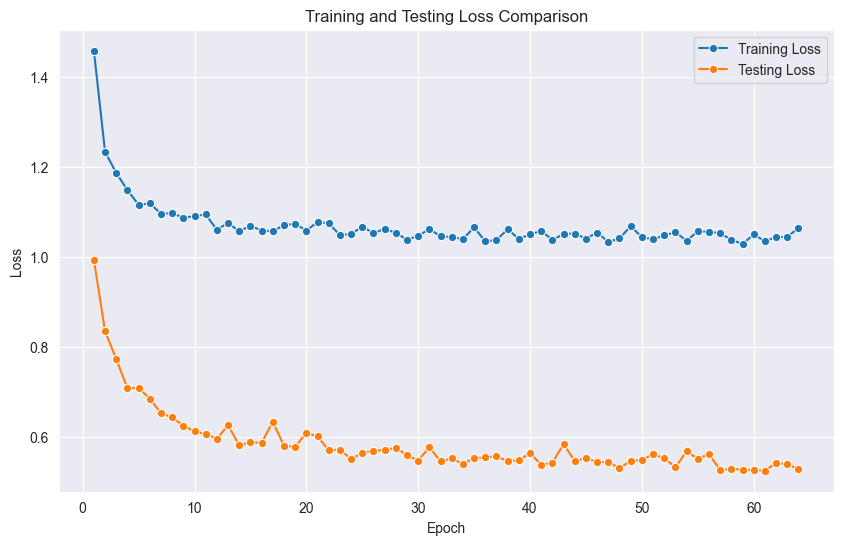

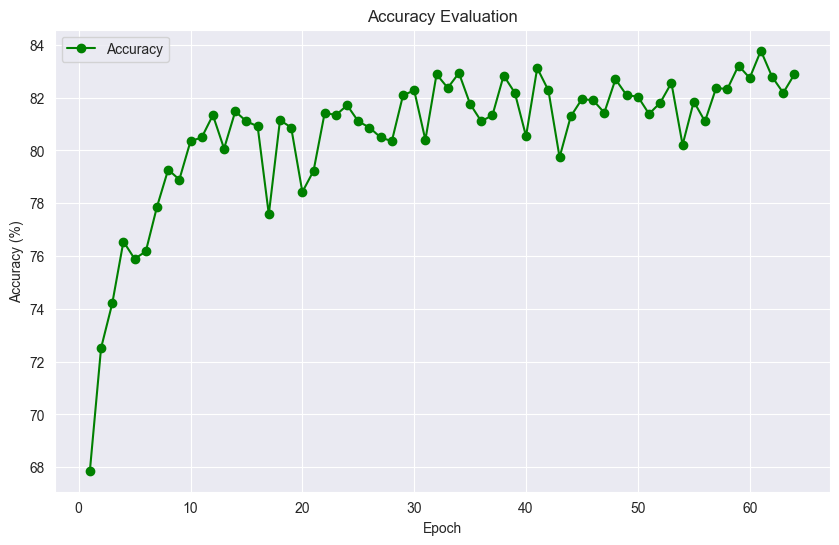

Historical data saved successfully!


In [33]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

hardware = torch.device('cuda' if   torch.cuda.is_available() else 'cpu')
classes = 6
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 64
criterion = nn.CrossEntropyLoss()

model = PestClassifierMobileNetV2(num_classes=classes).to(hardware)
# model.load_state_dict(torch.load('models/PestClassifierMobileNetV2.pth'))

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

# # Phase 1

result_1, accuracies = train_and_test(model=model, optimizer=optimizer, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=num_epochs, device=hardware)

plot_training_result(result_1)
plot_accuracy(result_1)
save_historical_data(result_1)


Unfreezing last block of feature extraction.


Test epoch: 1: 100%|██████████| 34/34 [00:07<00:00,  4.82it/s]


Epoch 1/64 | Train Loss: 1.1672 | Test Loss: 0.5826 | Accuracy: 80.96% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 2: 100%|██████████| 34/34 [00:05<00:00,  6.45it/s]


Epoch 2/64 | Train Loss: 1.0218 | Test Loss: 0.4679 | Accuracy: 84.47% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 3: 100%|██████████| 34/34 [00:05<00:00,  6.75it/s]


Epoch 3/64 | Train Loss: 0.9769 | Test Loss: 0.4131 | Accuracy: 85.83% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 4: 100%|██████████| 34/34 [00:06<00:00,  5.47it/s]


Epoch 4/64 | Train Loss: 0.9197 | Test Loss: 0.4028 | Accuracy: 86.73% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 5: 100%|██████████| 34/34 [00:04<00:00,  6.86it/s]


Epoch 5/64 | Train Loss: 0.9030 | Test Loss: 0.4000 | Accuracy: 86.07% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 6: 100%|██████████| 34/34 [00:05<00:00,  6.26it/s]


Epoch 6/64 | Train Loss: 0.8789 | Test Loss: 0.3831 | Accuracy: 87.29% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 7: 100%|██████████| 34/34 [00:08<00:00,  3.89it/s]


Epoch 7/64 | Train Loss: 0.8517 | Test Loss: 0.3908 | Accuracy: 86.59% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 8: 100%|██████████| 34/34 [00:13<00:00,  2.58it/s]


Epoch 8/64 | Train Loss: 0.8194 | Test Loss: 0.4396 | Accuracy: 84.99% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 9: 100%|██████████| 34/34 [00:12<00:00,  2.67it/s]


Epoch 9/64 | Train Loss: 0.8369 | Test Loss: 0.3886 | Accuracy: 86.40% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 10: 100%|██████████| 34/34 [00:12<00:00,  2.73it/s]


Epoch 10/64 | Train Loss: 0.8258 | Test Loss: 0.3873 | Accuracy: 86.30% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 11: 100%|██████████| 34/34 [00:13<00:00,  2.49it/s]


Epoch 11/64 | Train Loss: 0.8026 | Test Loss: 0.3288 | Accuracy: 89.21% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 12: 100%|██████████| 34/34 [00:11<00:00,  3.00it/s]


Epoch 12/64 | Train Loss: 0.7858 | Test Loss: 0.3404 | Accuracy: 89.07% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 13: 100%|██████████| 34/34 [00:10<00:00,  3.15it/s]


Epoch 13/64 | Train Loss: 0.7922 | Test Loss: 0.3142 | Accuracy: 89.96% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 14: 100%|██████████| 34/34 [00:14<00:00,  2.37it/s]


Epoch 14/64 | Train Loss: 0.7847 | Test Loss: 0.3082 | Accuracy: 90.06% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 15: 100%|██████████| 34/34 [00:11<00:00,  3.03it/s]


Epoch 15/64 | Train Loss: 0.7620 | Test Loss: 0.3249 | Accuracy: 88.98% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 16: 100%|██████████| 34/34 [00:12<00:00,  2.67it/s]


Epoch 16/64 | Train Loss: 0.8038 | Test Loss: 0.2920 | Accuracy: 90.67% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 17: 100%|██████████| 34/34 [00:11<00:00,  2.88it/s]


Epoch 17/64 | Train Loss: 0.7515 | Test Loss: 0.2948 | Accuracy: 90.53% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 18: 100%|██████████| 34/34 [00:12<00:00,  2.74it/s]


Epoch 18/64 | Train Loss: 0.7475 | Test Loss: 0.3068 | Accuracy: 90.71% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 19: 100%|██████████| 34/34 [00:05<00:00,  6.67it/s]


Epoch 19/64 | Train Loss: 0.7302 | Test Loss: 0.3015 | Accuracy: 89.49% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 20: 100%|██████████| 34/34 [00:05<00:00,  6.51it/s]


Epoch 20/64 | Train Loss: 0.7280 | Test Loss: 0.2940 | Accuracy: 89.92% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 21: 100%|██████████| 34/34 [00:05<00:00,  6.72it/s]


Epoch 21/64 | Train Loss: 0.7307 | Test Loss: 0.2827 | Accuracy: 91.28% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 22: 100%|██████████| 34/34 [00:05<00:00,  6.19it/s]


Epoch 22/64 | Train Loss: 0.7300 | Test Loss: 0.2847 | Accuracy: 90.90% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 23: 100%|██████████| 34/34 [00:06<00:00,  5.12it/s]


Epoch 23/64 | Train Loss: 0.7198 | Test Loss: 0.2750 | Accuracy: 90.99% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 24: 100%|██████████| 34/34 [00:06<00:00,  5.38it/s]


Epoch 24/64 | Train Loss: 0.7090 | Test Loss: 0.2891 | Accuracy: 91.18% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 25: 100%|██████████| 34/34 [00:06<00:00,  5.35it/s]


Epoch 25/64 | Train Loss: 0.7024 | Test Loss: 0.2862 | Accuracy: 90.95% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 26: 100%|██████████| 34/34 [00:06<00:00,  5.26it/s]


Epoch 26/64 | Train Loss: 0.7179 | Test Loss: 0.2681 | Accuracy: 91.42% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 27: 100%|██████████| 34/34 [00:05<00:00,  6.32it/s]


Epoch 27/64 | Train Loss: 0.6954 | Test Loss: 0.2778 | Accuracy: 90.90% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 28: 100%|██████████| 34/34 [00:05<00:00,  5.91it/s]


Epoch 28/64 | Train Loss: 0.6938 | Test Loss: 0.2713 | Accuracy: 91.93% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 29: 100%|██████████| 34/34 [00:05<00:00,  6.80it/s]


Epoch 29/64 | Train Loss: 0.6760 | Test Loss: 0.2863 | Accuracy: 90.62% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 30: 100%|██████████| 34/34 [00:04<00:00,  6.82it/s]


Epoch 30/64 | Train Loss: 0.6937 | Test Loss: 0.3132 | Accuracy: 90.06% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 31: 100%|██████████| 34/34 [00:05<00:00,  6.76it/s]


Epoch 31/64 | Train Loss: 0.6852 | Test Loss: 0.2792 | Accuracy: 91.79% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 32: 100%|██████████| 34/34 [00:05<00:00,  6.40it/s]


Epoch 32/64 | Train Loss: 0.6906 | Test Loss: 0.2878 | Accuracy: 91.04% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 33: 100%|██████████| 34/34 [00:04<00:00,  6.86it/s]


Epoch 33/64 | Train Loss: 0.6893 | Test Loss: 0.2617 | Accuracy: 92.31% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 34: 100%|██████████| 34/34 [00:05<00:00,  6.63it/s]


Epoch 34/64 | Train Loss: 0.6692 | Test Loss: 0.2700 | Accuracy: 91.65% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 35: 100%|██████████| 34/34 [00:07<00:00,  4.25it/s]


Epoch 35/64 | Train Loss: 0.6974 | Test Loss: 0.2574 | Accuracy: 91.93% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 36: 100%|██████████| 34/34 [00:07<00:00,  4.55it/s]


Epoch 36/64 | Train Loss: 0.6771 | Test Loss: 0.2606 | Accuracy: 91.84% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 37: 100%|██████████| 34/34 [00:05<00:00,  6.78it/s]


Epoch 37/64 | Train Loss: 0.6550 | Test Loss: 0.2725 | Accuracy: 91.84% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 38: 100%|██████████| 34/34 [00:05<00:00,  6.52it/s]


Epoch 38/64 | Train Loss: 0.6700 | Test Loss: 0.2534 | Accuracy: 91.93% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 39: 100%|██████████| 34/34 [00:11<00:00,  2.97it/s]


Epoch 39/64 | Train Loss: 0.6701 | Test Loss: 0.2416 | Accuracy: 92.40% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 40: 100%|██████████| 34/34 [00:12<00:00,  2.83it/s]


Epoch 40/64 | Train Loss: 0.6598 | Test Loss: 0.2617 | Accuracy: 92.26% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 41: 100%|██████████| 34/34 [00:10<00:00,  3.36it/s]


Epoch 41/64 | Train Loss: 0.6706 | Test Loss: 0.2389 | Accuracy: 92.96% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 42: 100%|██████████| 34/34 [00:10<00:00,  3.33it/s]


Epoch 42/64 | Train Loss: 0.6749 | Test Loss: 0.2383 | Accuracy: 92.59% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 43: 100%|██████████| 34/34 [00:11<00:00,  3.07it/s]


Epoch 43/64 | Train Loss: 0.6503 | Test Loss: 0.2503 | Accuracy: 92.50% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 44: 100%|██████████| 34/34 [00:10<00:00,  3.26it/s]


Epoch 44/64 | Train Loss: 0.6492 | Test Loss: 0.2618 | Accuracy: 91.89% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 45: 100%|██████████| 34/34 [00:10<00:00,  3.15it/s]


Epoch 45/64 | Train Loss: 0.6560 | Test Loss: 0.2498 | Accuracy: 92.82% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 46: 100%|██████████| 34/34 [00:16<00:00,  2.02it/s]


Epoch 46/64 | Train Loss: 0.6619 | Test Loss: 0.2590 | Accuracy: 92.50% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 47: 100%|██████████| 34/34 [00:12<00:00,  2.77it/s]


Epoch 47/64 | Train Loss: 0.6364 | Test Loss: 0.2509 | Accuracy: 92.31% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 48: 100%|██████████| 34/34 [00:05<00:00,  6.59it/s]


Epoch 48/64 | Train Loss: 0.6368 | Test Loss: 0.2352 | Accuracy: 93.01% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 49: 100%|██████████| 34/34 [00:05<00:00,  6.27it/s]


Epoch 49/64 | Train Loss: 0.6455 | Test Loss: 0.2561 | Accuracy: 92.12% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 50: 100%|██████████| 34/34 [00:05<00:00,  6.60it/s]


Epoch 50/64 | Train Loss: 0.6498 | Test Loss: 0.2373 | Accuracy: 92.64% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 51: 100%|██████████| 34/34 [00:05<00:00,  6.71it/s]


Epoch 51/64 | Train Loss: 0.6346 | Test Loss: 0.2435 | Accuracy: 92.73% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 52: 100%|██████████| 34/34 [00:11<00:00,  2.97it/s]


Epoch 52/64 | Train Loss: 0.6481 | Test Loss: 0.2629 | Accuracy: 92.54% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 53: 100%|██████████| 34/34 [00:09<00:00,  3.42it/s]


Epoch 53/64 | Train Loss: 0.6213 | Test Loss: 0.2642 | Accuracy: 91.84% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 54: 100%|██████████| 34/34 [00:11<00:00,  3.01it/s]


Epoch 54/64 | Train Loss: 0.6243 | Test Loss: 0.2481 | Accuracy: 92.68% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 55: 100%|██████████| 34/34 [00:11<00:00,  2.95it/s]


Epoch 55/64 | Train Loss: 0.6350 | Test Loss: 0.2737 | Accuracy: 91.37% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 56: 100%|██████████| 34/34 [00:10<00:00,  3.26it/s]


Epoch 56/64 | Train Loss: 0.6354 | Test Loss: 0.2561 | Accuracy: 92.21% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 57: 100%|██████████| 34/34 [00:11<00:00,  2.97it/s]


Epoch 57/64 | Train Loss: 0.6250 | Test Loss: 0.2454 | Accuracy: 92.92% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 58: 100%|██████████| 34/34 [00:05<00:00,  6.73it/s]


Epoch 58/64 | Train Loss: 0.6213 | Test Loss: 0.2403 | Accuracy: 92.50% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 59: 100%|██████████| 34/34 [00:05<00:00,  6.54it/s]


Epoch 59/64 | Train Loss: 0.5985 | Test Loss: 0.2454 | Accuracy: 92.64% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 60: 100%|██████████| 34/34 [00:05<00:00,  6.59it/s]


Epoch 60/64 | Train Loss: 0.6140 | Test Loss: 0.2408 | Accuracy: 92.78% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 61: 100%|██████████| 34/34 [00:10<00:00,  3.39it/s]


Epoch 61/64 | Train Loss: 0.6290 | Test Loss: 0.2327 | Accuracy: 93.06% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 62: 100%|██████████| 34/34 [00:11<00:00,  3.02it/s]


Epoch 62/64 | Train Loss: 0.6147 | Test Loss: 0.2580 | Accuracy: 92.59% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 63: 100%|██████████| 34/34 [00:11<00:00,  3.03it/s]


Epoch 63/64 | Train Loss: 0.6070 | Test Loss: 0.2281 | Accuracy: 93.43% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB


Test epoch: 64: 100%|██████████| 34/34 [00:10<00:00,  3.11it/s]


Epoch 64/64 | Train Loss: 0.6057 | Test Loss: 0.2383 | Accuracy: 92.78% | GPU Memory (Alloc/Reserved): 0.07/1.828 GB
Phase done!


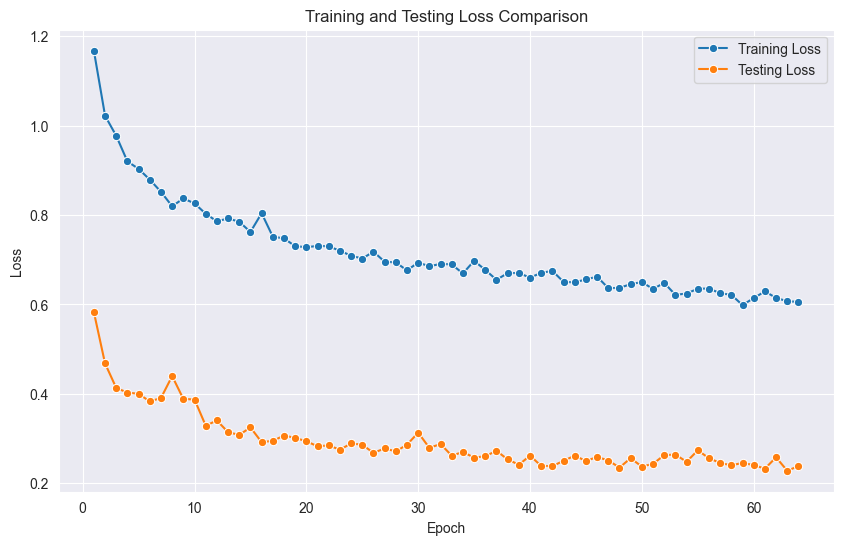

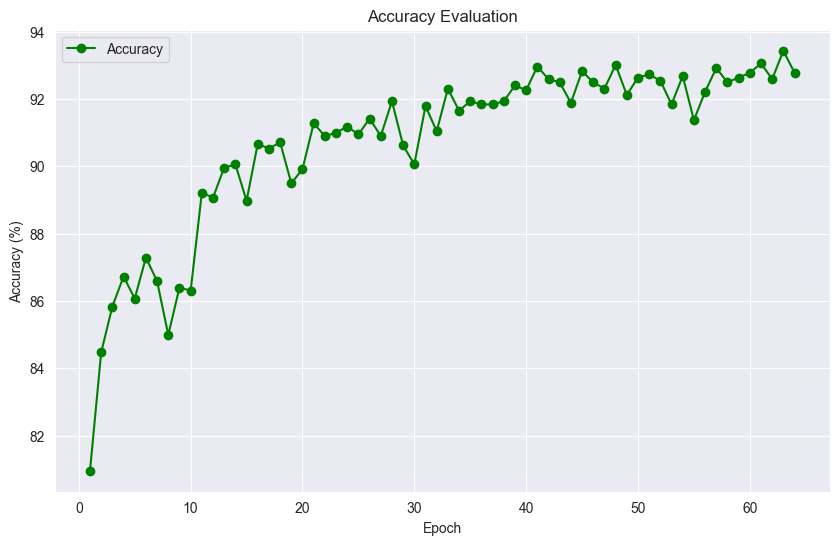

Historical data saved successfully!


In [34]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

hardware = torch.device('cuda' if  torch.cuda.is_available() else 'cpu')
classes = 6
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 32
criterion = nn.CrossEntropyLoss()

model = PestClassifierMobileNetV2(num_classes=classes).to(hardware)
model.load_state_dict(torch.load('models/SMobileNetV2_rice_pest_classificationV8.pt'))
model.unfreeze_last_block()

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=weight_decay)

# scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=4)

result_2, accuracies_2 = train_and_test(model=model, optimizer=optimizer, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=64, device=hardware)

# model.unfreeze_last_block()
# print('Phase 2 training')
#
# result_2, accuracies_2 = train_and_test(model=model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=64, device=hardware)
#
# model.unfreeze_final_invert_residual()
# print('Phase 3 training')
#
# result_3, accuracies_3 = train_and_test(model=model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=86, device=hardware)

plot_training_result(result_2)
plot_accuracy(result_2)
save_historical_data(result_2)

In [23]:
mobilenet_v3_large = models.mobilenet_v3_large(weights='MobileNet_V3_Large_Weights.IMAGENET1K_V2')
print(mobilenet_v3_large.classifier)

Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=1000, bias=True)
)


In [19]:
mobilenet_v2 = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V2')
print(mobilenet_v2.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [32]:
from PIL import Image
import torch.nn.functional as F

def predict_single_image(model, image_path, classes, transform, device):

    model.to(device)

    model.eval()

    image = Image.open(image_path).convert('RGB')

    image_np = np.array(image)

    augmented = transform(image=image_np)

    image_tensor = augmented['image'].unsqueeze(0).to(device)

    with torch.no_grad():

        result = model(image_tensor)

        probability = F.softmax(result, dim=1)

        confidence, predicted = torch.max(probability, 1)

        predicted_class = classes[predicted.item()]
        confidence_score = confidence.item()

    return predicted_class, confidence_score


In [63]:
import torchvision.models as models

classes_names = train_set.classes
hardware = torch.device('cuda' if   torch.cuda.is_available() else 'cpu')
model_inference = PestClassifierMobileNetV2(num_classes=len(classes_names))
model_inference.load_state_dict(torch.load('models/SMobileNetV2_rice_pest_classificationV8.pt', map_location=hardware))
image_path = 'unrelated_data/grasshoper.jpg'

pest, confidence_score = predict_single_image(model=model_inference, image_path=image_path, classes=classes_names, transform=validation_pipeline, device=hardware)

print(f"The predicted pest is: {pest}")
print(f"Confidence: {confidence_score * 100:.2f}%")

The predicted pest is: brown-planthopper
Confidence: 77.59%
